In [2]:
import os
import shutil
import random
from pathlib import Path
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from torchvision.datasets import ImageFolder


c:\Users\Jomar\VSCode\ML\BasicML\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
dataset_dir = 'brain_tumors'

target_dir = 'brain_tumors_dataset'

classes = ['yes', 'no']
split_ratio = 0.8

#create the dirs
for split in ['train', 'val']:
    for cls in classes:
        os.makedirs(os.path.join(target_dir, split, cls), exist_ok = True)

#split the dataset
for cls in classes:
    cls_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(cls_dir)
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    for images in train_images:
        src = os.path.join(cls_dir, images)
        dst = os.path.join(target_dir, 'train', cls, images)
        shutil.copy(src, dst)
    
    for images in val_images:
        src = os.path.join(cls_dir, images)
        dst = os.path.join(target_dir, 'val', cls, images)
        shutil.copy(src,dst)


print("✅ Dataset split into train/val successfully.")

✅ Dataset split into train/val successfully.


In [4]:

class PreLoadedDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform = None):
        self.dataset = ImageFolder(root = root_dir)
        self.transform = transform
        self.data = []
        self.labels = []

        #iterate over the datasets and load images into mem
        for path, label in self.dataset.samples:
            image = Image.open(path).convert('RGB')
            #if there is a transform apply it
            if self.transform:
                image = self.transform(image)
            #append the image and label to the lists
            self.data.append(image)
            self.labels.append(label)

        print("Loaded {} images from {}".format(len(self.data), root_dir))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [13]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]),
    'val':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
}

dataset_dir = Path(target_dir)

datasets_dict = {
    x: PreLoadedDataset(dataset_dir / x, transform=transform[x])
    for x in ['train', 'val']
}


dataloaders = {
    x: DataLoader(datasets_dict[x], batch_size = 32, shuffle = True, num_workers = 0, pin_memory= True)
    for x in ['train', 'val']
}

class_names = datasets.ImageFolder(os.path.join(dataset_dir, 'train')).classes


Loaded 247 images from brain_tumors_dataset\train
Loaded 89 images from brain_tumors_dataset\val


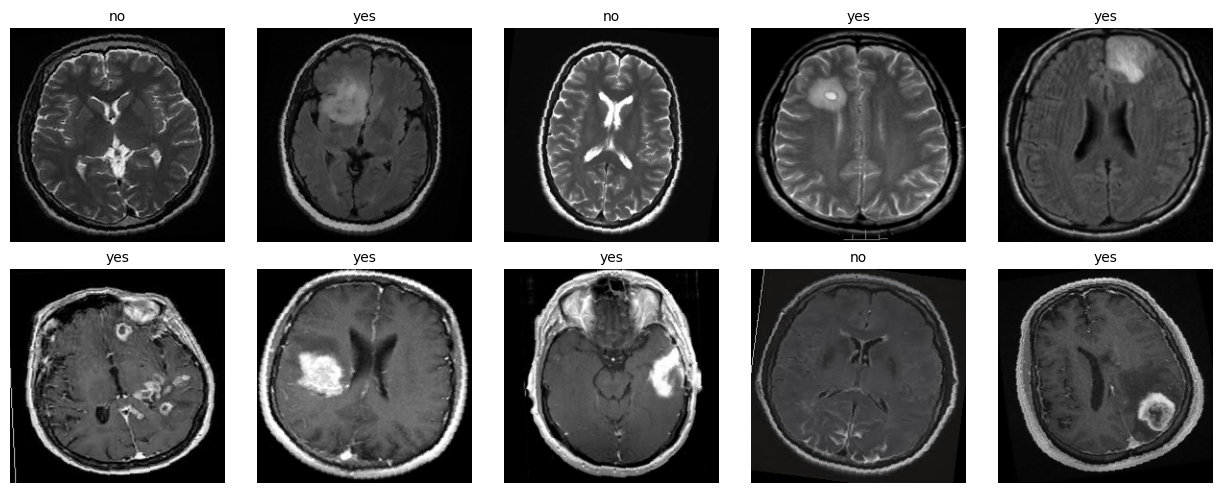

In [18]:
#view some samples

import matplotlib.pyplot as plt
import numpy as np

def imshow_batch(inputs, classes, class_names, num_images=10):
    #displays a batch of images
    inputs = inputs[:num_images]
    classes = classes[:num_images]
    
    # Setup subplot grid
    rows = 2
    cols = (num_images + 1) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()

    for idx, (img_tensor, label) in enumerate(zip(inputs, classes)):
        img = img_tensor.numpy().transpose((1, 2, 0))  # CHW → HWC
        img = (img * 0.5) + 0.5  # Unnormalize
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].set_title(class_names[label], fontsize=10)
        axes[idx].axis('off')

    # Hide unused subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

inputs, classes = next(iter(dataloaders['train']))
imshow_batch(inputs, classes, class_names, num_images=10)

In [20]:
#determine if we have a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [21]:
# load the pre-trained efficientnet model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)

# Move model to GPU if available
model = model.to(device)

c:\Users\Jomar\VSCode\ML\BasicML\ML\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jomar\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [22]:
#set up optimizer and loss func
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [25]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs = 10):
    for epoch in range(num_epochs):
        print("Epocj {}/{}".format(epoch + 1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #get the predicted class
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #if phase == train then backprop and optmize 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    #stats
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()/len (dataloaders[phase].dataset)
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

    return model

model = train_model(model, dataloaders, criterion, optimizer, num_epochs = 10)

Epocj 1/10
train Loss: 1.4319 Acc: 0.7976
val Loss: 1.2759 Acc: 0.8090
Epocj 2/10
train Loss: 0.5855 Acc: 0.9271
val Loss: 0.5156 Acc: 0.9326
Epocj 3/10
train Loss: 0.1449 Acc: 0.9717
val Loss: 0.2388 Acc: 0.9551
Epocj 4/10
train Loss: 0.2219 Acc: 0.9676
val Loss: 0.4297 Acc: 0.9326
Epocj 5/10
train Loss: 0.3803 Acc: 0.9474
val Loss: 0.4188 Acc: 0.9438
Epocj 6/10
train Loss: 0.2566 Acc: 0.9636
val Loss: 0.0575 Acc: 0.9663
Epocj 7/10
train Loss: 0.1209 Acc: 0.9798
val Loss: 0.0032 Acc: 1.0000
Epocj 8/10
train Loss: 0.1040 Acc: 0.9757
val Loss: 0.1014 Acc: 0.9775
Epocj 9/10
train Loss: 0.0678 Acc: 0.9838
val Loss: 0.0041 Acc: 1.0000
Epocj 10/10
train Loss: 0.0449 Acc: 0.9919
val Loss: 0.0219 Acc: 0.9888


In [26]:
def evaluate_model(model):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs,labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Classification Summary:")
    print(classification_report(y_true, y_pred, target_names = class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

evaluate_model(model)

Classification Summary:
              precision    recall  f1-score   support

          no       1.00      0.97      0.99        36
         yes       0.98      1.00      0.99        53

    accuracy                           0.99        89
   macro avg       0.99      0.99      0.99        89
weighted avg       0.99      0.99      0.99        89

Confusion Matrix:
[[35  1]
 [ 0 53]]


In [ ]:
import random
import torch.nn.functional as F

def predict_image(model, dataloader, class_names, device):
    model.eval()
    
    #randomly select an image
    dataset = dataloader.dataset
    random_index = random.randint(0, len(dataset) - 1)
    image,label = dataset[random_index]

    #add batch dimension and move to device
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim = 1).cpu().numpy()
        predicted_class = torch.argmax(outputs, dim=1).item()

    #unnormalize the image
    img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = (img * 0.5) + 0.5  # reverse normalization

    plt.imshow(img)
    plt.axis('off')
    plt.title(
    "True: {}\nPred: {} ({:.1f}%)\nOther: {} ({:.1f}%)".format(
        class_names[label],
        class_names[predicted_class],
        probabilities[0][predicted_class] * 100,
        class_names[1 - predicted_class],
        probabilities[0][1 - predicted_class] * 100
        )
    )
    plt.show()

predict_image(model, dataloaders['val'], class_names, device)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3